# Ternary routing between experts
- The model resembles mixture of experts.
- Define expert networks that are small networks and they need to interact with networks up the hierarchy.
- The interaction is mediated by a routing matrix.

## Preliminary Experiment Design

### Design a ternary differentiable rule
- Using Trident framework, to be able to backprop through the ternary matrix of connectivity.

### Build a MoE model
- Experets of certain size talking across hierarchy.

### Test out with synthetic data
- Define random test inputs and labels.
- Assign them different penalty weights.

### Potential questions to ask
- Does the number of routing connections go up when the surprising/critical inputs are presented?
- What happens to the balance condition?


In [9]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
from flax.nnx.nn import initializers
import optax
from typing import Callable
from tqdm.notebook import tqdm
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from collections import defaultdict

# Define the trident-ternary activation

In [4]:
def ternary_activation(x, thresholds, noise_sd, key):
    """
    Ternary activation function
    """
    # key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise


    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

# helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e

# custom gradients

@jax.custom_vjp
def trident(x, thresholds, noise_sd, key):
    return ternary_activation(x = x, thresholds = thresholds, noise_sd = noise_sd, key = key) # call the ternary activation in the forward pass

def trident_fwd(x, thresholds, noise_sd, key):
    return trident(x, thresholds, noise_sd, key), (x, thresholds, noise_sd) # save the inputs, thresholds, noise_sd for the backward pass

def trident_bwd(residuals, grads):
    x, thresholds, noise_sd = residuals # unpack the residuals from forward pass
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad*grads, None, None, None)

trident.defvjp(trident_fwd, trident_bwd)



Text(0, 0.5, 'Custom Gradient')

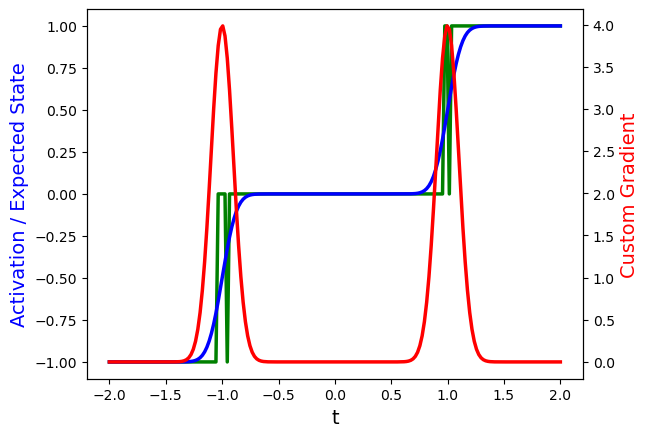

In [3]:
## testing
kk = jax.random.key(0)
t = jnp.linspace(-2, 2, 200)
th = [-1.0, 1.0]
noise_sd = 0.1
act = ternary_activation(t, th, 0.1, kk)
exp_st = expected_state(t, th, noise_sd)
cus_grad = jax.vmap(jax.grad(trident), in_axes=(0, None, None, None))(t, th, noise_sd, kk)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, act, 'g-', lw = 2.5)
ax1.plot(t, exp_st, 'b-', lw = 2.5)
ax2.plot(t, cus_grad, 'r-', lw = 2.5)

ax1.set_xlabel('t', fontsize = 14)
ax1.set_ylabel('Activation / Expected State', color='b', fontsize = 14)
ax2.set_ylabel('Custom Gradient', color='r', fontsize = 14)

In [4]:
## testing 2
key = jax.random.key(4562)
x_test = jax.random.normal(key, (10, 100))
th_test = [-0.5, 0.5]
noise_sd_test = 0.1
# outs = jax.vmap(trident, in_axes=(0, None, None, None))(x_test, th_test, noise_sd_test, key)
outs = trident(x_test, th_test, noise_sd_test, key)
print(outs.shape, "\n", outs)

(10, 100) 
 [[ 0. -1. -1.  0. -1. -1.  0. -1.  1.  0.  0. -1.  0.  1. -1. -1. -1. -1.
   1.  1. -1.  1.  1. -1. -1.  1. -1.  0.  1.  0. -1. -1.  0. -1.  1.  0.
   0.  0. -1.  1. -1.  0. -1.  1. -1. -1.  0. -1. -1. -1.  0. -1.  0. -1.
  -1.  1.  1. -1. -1.  1.  0.  0. -1.  1.  1.  0. -1.  0. -1.  1.  1. -1.
   1. -1. -1.  0.  0. -1.  0. -1.  0.  1. -1.  1.  1. -1.  1. -1. -1.  1.
  -1.  1.  0.  1. -1.  0.  0.  0. -1. -1.]
 [-1.  1. -1. -1.  0. -1.  0.  0. -1.  0.  0.  1.  0.  1. -1.  1. -1.  0.
   1.  1.  0.  0.  0. -1. -1. -1.  1. -1.  0.  0. -1.  1. -1.  0.  0.  1.
  -1. -1.  1. -1.  0.  0. -1.  1.  0.  0. -1.  1. -1.  1. -1. -1.  1. -1.
   1.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0. -1. -1. -1.  0. -1.  0.
   1.  0.  1.  1.  1.  1. -1.  1.  0.  1.  1. -1.  1.  0.  1. -1.  0. -1.
   1.  1.  0. -1.  1. -1. -1. -1.  1.  0.]
 [-1.  1.  0.  1.  0.  0. -1. -1.  0.  1. -1.  0.  0. -1.  0. -1. -1.  1.
  -1.  0.  1. -1. -1. -1.  0.  1.  0.  0. -1. -1. -1. -1. -1.  0.  1. -1.
   1.  0.  0. 

## Define a toy MoE model
- Each expert is parametrized by a $n\times m$ matrix. For ease we can start with $n = m = 10$
- Define routing matrices between the hierarchical level. Every element of this matrix $\mathbf{C}_{ij} ~ \forall ~ i,j  \in \{-1, 0, +1\}$.
- Apply any activation to the experts.
- Apply trident to the routing matrices

In [5]:
class TridentMOELayer(nnx.Module):

    def __init__(self, 
                 in_features: int, # input feature dimension
                 num_experts: int, # number of smaller experts
                 expert_size: int, # size of each expert
                 rngs: nnx.Rngs,
                 thresholds: list = [-0.5, 0.5], # thresholds for ternary activation
                 noise_sd: float = 0.1, # standard deviation of the noise injected before ternary activation
                 ):
        
        self.in_features = in_features
        self.num_experts = num_experts
        self.expert_size = expert_size
        self.rngs = rngs
        self.thresholds = thresholds
        self.noise_sd = noise_sd
        
        # compute the size of the routing matrix
        in_chunks = math.ceil(in_features/expert_size) # find the number of chuks of in the input that the experts will handle

        glorot_init = initializers.glorot_normal()
        self.routing_matrix = nnx.Param(
            glorot_init(rngs.params(), (in_chunks, num_experts))
        )

        # define the weights of the experts
        self.We = nnx.Param(
            glorot_init(rngs.params(), (num_experts, expert_size, expert_size))
        )

    def __call__(self, x: jnp.array) -> jnp.array:
        """
        Forward pass through the layer
        Args:
        x: input array of shape (samples/batch size, in_features)
        """

        # reshape x into chunks of expert size
        x = x.reshape(x.shape[0], -1, self.expert_size)

        # print(x.shape)
        # print(self.routing_matrix.shape)

        # make sure that the the routing matrix is ternary
        ternary_routing = trident(self.routing_matrix.value, self.thresholds, self.noise_sd, self.rngs.dropout())

        # route the inputs to the experts
        x_routed = jnp.einsum('ik, bij -> bkj', ternary_routing, x) # shape (batch size, num_experts, expert_size)

        # pass the routed inputs through experts
        x_experts = jnp.einsum('eij, bej -> bei', self.We.value, x_routed) # shape (batch size, num_experts, expert_size)

        # combine the outputs of the experts
        y = x_experts.reshape(x.shape[0], -1) # shape (batch size, num_experts * expert_size)

        return y
    
    def get_routing_matrix(self, apply_activation: bool = False):
        if apply_activation:
            return trident(self.routing_matrix.value, self.thresholds, self.noise_sd, self.rngs.dropout())
        else:
            return self.routing_matrix.value





x_test shape: (10, 100)


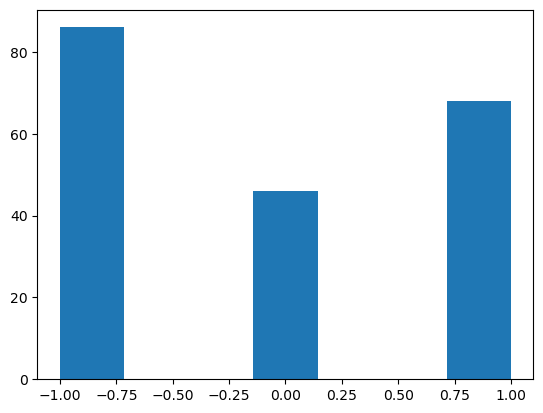

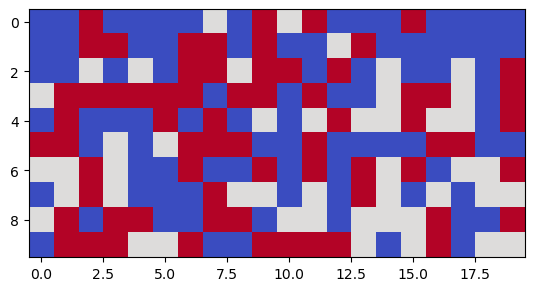

In [6]:
## testing the layer
key = jax.random.key(4562)
rngs = nnx.Rngs(params=0, dropout=1)
x_test = jax.random.normal(rngs.params(), (10, 100))
print(f"x_test shape: {x_test.shape}")

test_layer = TridentMOELayer(
    in_features=x_test.shape[1],
    num_experts=20,
    expert_size=10,
    rngs=rngs,
    thresholds=[-0.1, 0.1],
    noise_sd=0.1
)

Cr = test_layer.get_routing_matrix(apply_activation=True)

plt.figure()
plt.hist(Cr.flatten(), bins=7)

plt.figure()
plt.imshow(Cr, cmap='coolwarm', vmin=-1, vmax=1)


# nnx.display(test_layer)
# outs = test_layer(x_test)
# print(f"outs.shape: {outs.shape}")
# print(f"outs[0, :20]: {outs[0, :20]}")

del test_layer

In [6]:
## build a network with one hidden layer of experts
class TridentMOENet(nnx.Module):

    def __init__(self, 
                 in_features: int, 
                 expert_size: int, 
                 rngs: nnx.Rngs,
                 thresholds: list = [-0.5, 0.5], 
                 noise_sd: float = 0.1, 
                 layer_sizes: list = [30, 10], # in terms of number of experts
                 ):
        self.in_features = in_features
        self.expert_size = expert_size
        self.rngs = rngs
        self.thresholds = thresholds
        self.noise_sd = noise_sd
        self.in_chunks = math.ceil(in_features/expert_size)

        layer_sizes.insert(0, self.in_chunks)
        self.layer_sizes = layer_sizes

        self.layers = [
            TridentMOELayer(
                in_features=li*self.expert_size,
                num_experts=lo,
                expert_size=self.expert_size,
                rngs=self.rngs,
                thresholds=self.thresholds,
                noise_sd=self.noise_sd
            )

            for li, lo in zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        ]

    def __call__(self, x: jnp.array) -> jnp.array:
        for layer in self.layers:
            x = layer(x)
        return x
    




In [8]:
## testing the network
key = jax.random.key(462)
rngs = nnx.Rngs(params=0, dropout=1)
x_test = jax.random.normal(rngs.params(), (10, 100))
print(f"x_test shape: {x_test.shape}")

test_net = TridentMOENet(
    in_features=x_test.shape[1],
    # num_experts=20,
    expert_size=10,
    rngs=rngs,
    thresholds=[-0.5, 0.5],
    noise_sd=0.1,
    layer_sizes=[30, 10]
)
nnx.display(test_net)

outs = test_net(x_test)
print(f"outs.shape: {outs.shape}")


x_test shape: (10, 100)


outs.shape: (10, 100)


In [9]:
## Now define test inputs and labels...
def generate_random_inputs_and_labels(
        batch_size: int,
        in_features:int,
        label_size: int,
        rngs: nnx.Rngs,
):
    test_inputs = jax.random.normal(rngs.params(), (batch_size, in_features))
    test_labels = jax.random.randint(rngs.params(), (batch_size, ), 0, label_size)
    return test_inputs, test_labels



In [11]:
## generate dataset fromn sklearn
def generate_classification_data(
        n_smaples: int = 500,
        n_features: int = 30,
        n_informative: int = 20,
        n_redundant: int = 5,
        n_classes: int = 10,
        n_clusters_per_class: int = 2,
        class_sep: float = 1.5,
        flip_f: float = 0.01,
        random_state = 101,
        train_size: float = 0.8
):
    X, y = make_classification(
        n_samples=n_smaples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        flip_y=flip_f,
        random_state=random_state
    )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_train = jnp.array(X_train)
    X_test = jnp.array(X_test)
    y_train = jnp.array(y_train)
    y_test = jnp.array(y_test)

    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = generate_classification_data()
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (400, 30), y_train shape: (400,)


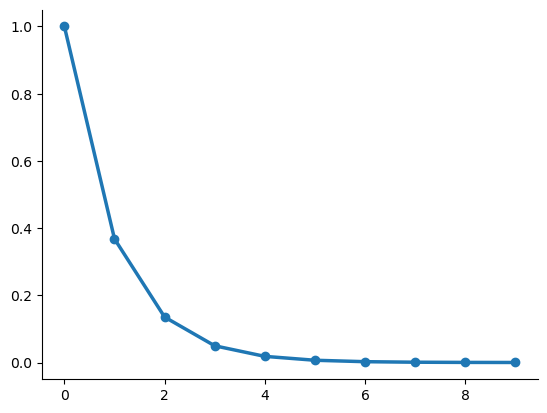

In [10]:
# define a function that weights labels by importance
def label_weights(label_input: int, tau: float = 1.0, scaling_constant: float = 1.0) -> float:
    return scaling_constant * jnp.exp(-label_input / tau)

# testing
label_list = jnp.arange(10)
weights = label_weights(label_list, tau = 1.0, scaling_constant = 1.0)

fig, ax = plt.subplots()
ax.plot(label_list, weights, lw=2.5, marker='o')

sns.despine()

## Defining training functions

In [12]:
# ce loss function
def loss_function(model: TridentMOENet,
                  inputs: jax.Array,
                  labels: jax.Array,
                  num_categories: int = 10):

    
    logits = model(inputs) # forward pass

    # reshape the inputs
    logits = logits.reshape(logits.shape[0], num_categories, -1)

    # find the mean across the last dimension
    logits = jnp.mean(logits, axis=-1) # shape of logits is (batch size, num_categories)

    # compute cross entropy loss
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()

    return loss, logits

# weighted loss function
# def weighted_loss_function(
#         model: TridentMOENet,
#         inputs: jax.Array,
#         labels: jax.Array,
        
# ):


# training step
@nnx.jit
def train_step(model: TridentMOENet,
               optimizer: nnx.Optimizer,
               metrics: nnx.MultiMetric,
               inputs: jax.Array,
               labels: jax.Array,
               loss_fn: Callable = loss_function,
               ):
    
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, inputs, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)
    optimizer.update(grads)

# evaluation function
@nnx.jit
def eval_step(
    model: TridentMOENet,
    metrics: nnx.MultiMetric,
    inputs: jax.Array,
    labels: jax.Array,
    loss_fn: Callable = loss_function,
):
    loss, logits = loss_fn(model, inputs, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)

# prediction step
@nnx.jit
def pred_step(
    model: TridentMOENet,
    inputs: jax.Array
):
    logits = model(inputs) # forward pass

    # reshape the inputs
    logits = logits.reshape(logits.shape[0], -1, 10)

    # find the mean across the last dimension
    logits = jnp.mean(logits, axis=-1) # shape of logits is (batch size, num_categories)

    # prediction is the argmax
    preds = logits.argmax(axis=-1)

    return preds



In [12]:
# testing
rngs = nnx.Rngs(params=0, dropout=1)
test_input, test_labels = generate_random_inputs_and_labels(batch_size=10, in_features=100, label_size=10, rngs=rngs)
loss, logits = loss_function(test_net, test_input, test_labels)

print(f"loss: {loss}")
print(f"logits: {logits}")

# test predictions
test_preds = pred_step(test_net, test_input)
print(f"test_preds: {test_preds}")



loss: 2.3029839992523193
logits: [[ 0.          0.          0.          0.         -0.02910635  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.00196482  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.01726707  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.0109135   0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.01445772  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00262936  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.02819263  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.01147936  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.  

In [54]:
# training loop
rngs = nnx.Rngs(params=13, dropout=5647)
model = TridentMOENet(
    in_features=X_train.shape[1],
    # num_experts=20,
    expert_size=10,
    rngs=rngs,
    thresholds=[-0.3, 0.3],
    noise_sd=0.1,
    layer_sizes=[30, 10]
)

# optimizers
hyperparameters = {
    'learning_rate': 0.5e-3, # 1e-3 seems to work well
    'momentum': 0.9, 
    'weight_decay': 1e-4
}

optimizer = nnx.Optimizer(
    model,
    optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
)

metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss')
)

metrics_history = defaultdict(list)

# rngs = nnx.Rngs(params=0, dropout=1)
# test_input, test_labels = generate_random_inputs_and_labels(batch_size=10, in_features=100, label_size=10, rngs=rngs)


In [61]:
def training_loop(
        # model: TridentMOENet = model,
        # optimizer: nnx.Optimizer = optimizer,
        inputs: jax.Array = X_train,
        labels: jax.Array = y_train,
        test_inputs: jax.Array = X_test,
        test_labels: jax.Array = y_test,
        num_epochs: int = 1000,
        eval_every: int = 50,
):
    key1 = jax.random.key(0)
    
    for r in range(10):
        key1, key2 = jax.random.split(key1, 2)
        rngs = nnx.Rngs(params=key1, dropout=key2)
        model = TridentMOENet(
            in_features=X_train.shape[1],
            # num_experts=20,
            expert_size=10,
            rngs=rngs,
            thresholds=[-0.3, 0.3],
            noise_sd=0.1,
            layer_sizes=[30, 10]
        )

        optimizer = nnx.Optimizer(
        model,
        optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
        )

        metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss')
)

        for epoch in tqdm(range(num_epochs), desc="Training Progress"):
            train_step(model, optimizer, metrics, inputs, labels)

            if epoch > 0 and (epoch % eval_every == 0 or epoch == num_epochs - 1):
                # print(f"Epoch {epoch+1}/{num_epochs}")

                # for metric, value in metrics.compute().items():
                #     metrics_history[f"train_{metric}"].append(float(value))
                # metrics.reset()

                eval_step(model, metrics, test_inputs, test_labels)

                for metric, value in metrics.compute().items():
                    metrics_history[f"eval_{metric}"].append(float(value))
                metrics.reset()       

            # print(metrics_history)

                # print(f"Epoch {epoch+1}, Loss: {metrics_history['eval_loss'][-1]:.4f}, Accuracy: {metrics_history['eval_accuracy'][-1]*100:.2f}%")

        print(f"Resample: {r+1}/10, Final Eval Accuracy: {metrics_history['eval_accuracy'][-1]*100:.2f}%")

In [62]:
training_loop()

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 1/10, Final Eval Accuracy: 66.15%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 2/10, Final Eval Accuracy: 65.93%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 3/10, Final Eval Accuracy: 65.98%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 4/10, Final Eval Accuracy: 66.66%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 5/10, Final Eval Accuracy: 65.96%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 6/10, Final Eval Accuracy: 65.49%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 7/10, Final Eval Accuracy: 65.80%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 8/10, Final Eval Accuracy: 65.57%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 9/10, Final Eval Accuracy: 66.40%


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Resample: 10/10, Final Eval Accuracy: 66.09%


## Characterizing effect of routing sparsity on network performance

In [16]:
def sparsity_analysis(
    threshold: float, # [-threshold, threshold] will be used as the thresholds for trident
    inputs: jax.Array,
    labels: jax.Array,
    rngs: nnx.Rngs,
    num_epochs: int = 1000,
    eval_every: int = 50,
):
    # define the model
    model = TridentMOENet(
        in_features=inputs.shape[1],
        expert_size=10,
        rngs=rngs,
        thresholds=[-threshold, threshold],
        noise_sd=0.1
    )

    # optimizers
    hyperparameters = {
        'learning_rate': 1e-3, # 1e-3 seems to work well
        'momentum': 0.9, 
        'weight_decay': 1e-4
    }

    optimizer = nnx.Optimizer(
        model,
        optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
    )

    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss')
    )

    metrics_history = defaultdict(list)
    results_dict = defaultdict(list)

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        train_step(model, optimizer, metrics, inputs, labels)

        if epoch > 0 and (epoch % eval_every == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # for metric, value in metrics.compute().items():
            #     metrics_history[f"train_{metric}"].append(float(value))
            # metrics.reset()

            eval_step(model, metrics, inputs, labels)

            for metric, value in metrics.compute().items():
                metrics_history[f"eval_{metric}"].append(float(value))
            metrics.reset()       

        # print(metrics_history)

            print(f"Epoch {epoch+1}, Loss: {metrics_history['eval_loss'][-1]:.4f}, Accuracy: {metrics_history['eval_accuracy'][-1]*100:.2f}%")

    # # append the performance and threshold to results_dict
    # results_dict['threshold'].append(float(threshold))
    # results_dict['accuracy'].append(float(metrics_history['eval_accuracy'][-1]))
    # results_dict['loss'].append(float(metrics_history['eval_loss'][-1]))
    # results_dict['resample'].append(int(resample))

    return model, metrics_history

    

In [ ]:
thresholds_arr = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
key1 = jax.random.key(234)
num_resamples = 1
results_dict = defaultdict(list)
for r in tqdm(range(num_resamples), desc="Resample Progress"):
    for i_th, th in tqdm(enumerate(thresholds_arr), total=len(thresholds_arr), desc="Sparsity Analysis Progress"):
        print(f"Testing for threshold {th}")
        key1, key2 = jax.random.split(key1, 2)
        rngs = nnx.Rngs(params=key1, dropout=key2)

        model, metrics_history = sparsity_analysis(
            threshold=th,
            inputs=test_input,
            labels=test_labels,
            rngs=rngs,
        )

        # append the performance and threshold to results_dict
        results_dict['threshold'].append(float(th))
        results_dict['accuracy'].append(float(metrics_history['eval_accuracy'][-1]))
        results_dict['loss'].append(float(metrics_history['eval_loss'][-1]))
        results_dict['resample'].append(int(r))

print(results_dict)

Resample Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Sparsity Analysis Progress:   0%|          | 0/7 [00:00<?, ?it/s]

Testing for threshold 0.001


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 1.5279, Accuracy: 47.31%
Epoch 101/1000
Epoch 101, Loss: 0.1719, Accuracy: 94.71%
Epoch 151/1000
Epoch 151, Loss: 0.0467, Accuracy: 98.43%
Epoch 201/1000
Epoch 201, Loss: 0.0393, Accuracy: 98.24%
Epoch 251/1000
Epoch 251, Loss: 0.0133, Accuracy: 99.80%
Epoch 301/1000
Epoch 301, Loss: 0.0269, Accuracy: 99.02%
Epoch 351/1000
Epoch 351, Loss: 0.0131, Accuracy: 99.41%
Epoch 401/1000
Epoch 401, Loss: 0.0085, Accuracy: 99.80%
Epoch 451/1000
Epoch 451, Loss: 0.0213, Accuracy: 99.22%
Epoch 501/1000
Epoch 501, Loss: 0.0386, Accuracy: 98.24%
Epoch 551/1000
Epoch 551, Loss: 0.0071, Accuracy: 99.80%
Epoch 601/1000
Epoch 601, Loss: 0.0062, Accuracy: 99.61%
Epoch 651/1000
Epoch 651, Loss: 0.0005, Accuracy: 100.00%
Epoch 701/1000
Epoch 701, Loss: 0.0400, Accuracy: 99.02%
Epoch 751/1000
Epoch 751, Loss: 0.0145, Accuracy: 99.22%
Epoch 801/1000
Epoch 801, Loss: 0.0211, Accuracy: 99.41%
Epoch 851/1000
Epoch 851, Loss: 0.0030, Accuracy: 99.80%
Epoch 901/1000
Epoch 901, Loss: 

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 1.4897, Accuracy: 51.73%
Epoch 101/1000
Epoch 101, Loss: 0.1876, Accuracy: 92.94%
Epoch 151/1000
Epoch 151, Loss: 0.0680, Accuracy: 97.25%
Epoch 201/1000
Epoch 201, Loss: 0.0441, Accuracy: 97.65%
Epoch 251/1000
Epoch 251, Loss: 0.0306, Accuracy: 99.02%
Epoch 301/1000
Epoch 301, Loss: 0.0480, Accuracy: 98.24%
Epoch 351/1000
Epoch 351, Loss: 0.0157, Accuracy: 99.22%
Epoch 401/1000
Epoch 401, Loss: 0.0347, Accuracy: 98.82%
Epoch 451/1000
Epoch 451, Loss: 0.0406, Accuracy: 98.24%
Epoch 501/1000
Epoch 501, Loss: 0.0607, Accuracy: 98.43%
Epoch 551/1000
Epoch 551, Loss: 0.0451, Accuracy: 98.24%
Epoch 601/1000
Epoch 601, Loss: 0.0442, Accuracy: 99.22%
Epoch 651/1000
Epoch 651, Loss: 0.0327, Accuracy: 99.61%
Epoch 701/1000
Epoch 701, Loss: 0.0400, Accuracy: 98.63%
Epoch 751/1000
Epoch 751, Loss: 0.0652, Accuracy: 98.04%
Epoch 801/1000
Epoch 801, Loss: 0.0199, Accuracy: 99.22%
Epoch 851/1000
Epoch 851, Loss: 0.0215, Accuracy: 99.41%
Epoch 901/1000
Epoch 901, Loss: 0

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 1.6039, Accuracy: 46.54%
Epoch 101/1000
Epoch 101, Loss: 0.3180, Accuracy: 90.00%
Epoch 151/1000
Epoch 151, Loss: 0.1251, Accuracy: 96.27%
Epoch 201/1000
Epoch 201, Loss: 0.0855, Accuracy: 97.25%
Epoch 251/1000
Epoch 251, Loss: 0.0644, Accuracy: 97.06%
Epoch 301/1000
Epoch 301, Loss: 0.0462, Accuracy: 98.82%
Epoch 351/1000
Epoch 351, Loss: 0.0121, Accuracy: 99.61%
Epoch 401/1000
Epoch 401, Loss: 0.0094, Accuracy: 99.80%
Epoch 451/1000
Epoch 451, Loss: 0.0062, Accuracy: 99.80%
Epoch 501/1000
Epoch 501, Loss: 0.0223, Accuracy: 98.82%
Epoch 551/1000
Epoch 551, Loss: 0.0378, Accuracy: 98.04%
Epoch 601/1000
Epoch 601, Loss: 0.1311, Accuracy: 96.86%
Epoch 651/1000
Epoch 651, Loss: 0.0368, Accuracy: 98.82%
Epoch 701/1000
Epoch 701, Loss: 0.0007, Accuracy: 100.00%
Epoch 751/1000
Epoch 751, Loss: 0.0067, Accuracy: 99.80%
Epoch 801/1000
Epoch 801, Loss: 0.0346, Accuracy: 99.22%
Epoch 851/1000
Epoch 851, Loss: 0.1230, Accuracy: 98.24%
Epoch 901/1000
Epoch 901, Loss: 

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 1.3507, Accuracy: 53.08%
Epoch 101/1000
Epoch 101, Loss: 0.1996, Accuracy: 93.14%
Epoch 151/1000
Epoch 151, Loss: 0.0324, Accuracy: 98.43%
Epoch 201/1000
Epoch 201, Loss: 0.0075, Accuracy: 99.80%
Epoch 251/1000
Epoch 251, Loss: 0.0283, Accuracy: 98.82%
Epoch 301/1000
Epoch 301, Loss: 0.0310, Accuracy: 99.02%
Epoch 351/1000
Epoch 351, Loss: 0.0462, Accuracy: 98.82%
Epoch 401/1000
Epoch 401, Loss: 0.1079, Accuracy: 98.24%
Epoch 451/1000
Epoch 451, Loss: 0.1265, Accuracy: 97.25%
Epoch 501/1000
Epoch 501, Loss: 0.2294, Accuracy: 94.90%
Epoch 551/1000
Epoch 551, Loss: 0.1210, Accuracy: 97.65%
Epoch 601/1000
Epoch 601, Loss: 0.0162, Accuracy: 99.22%
Epoch 651/1000
Epoch 651, Loss: 0.0051, Accuracy: 99.80%
Epoch 701/1000
Epoch 701, Loss: 0.0067, Accuracy: 99.61%
Epoch 751/1000
Epoch 751, Loss: 0.0459, Accuracy: 99.22%
Epoch 801/1000
Epoch 801, Loss: 0.0755, Accuracy: 98.43%
Epoch 851/1000
Epoch 851, Loss: 0.0002, Accuracy: 100.00%
Epoch 901/1000
Epoch 901, Loss: 

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 1.4200, Accuracy: 51.54%
Epoch 101/1000
Epoch 101, Loss: 0.2087, Accuracy: 93.92%
Epoch 151/1000
Epoch 151, Loss: 0.0404, Accuracy: 98.63%
Epoch 201/1000
Epoch 201, Loss: 0.0469, Accuracy: 98.24%
Epoch 251/1000
Epoch 251, Loss: 0.0412, Accuracy: 99.02%
Epoch 301/1000
Epoch 301, Loss: 0.0769, Accuracy: 97.45%
Epoch 351/1000
Epoch 351, Loss: 0.0924, Accuracy: 96.86%
Epoch 401/1000
Epoch 401, Loss: 0.0407, Accuracy: 98.63%
Epoch 451/1000
Epoch 451, Loss: 0.0488, Accuracy: 98.63%
Epoch 501/1000
Epoch 501, Loss: 0.0098, Accuracy: 99.61%
Epoch 551/1000
Epoch 551, Loss: 0.0369, Accuracy: 99.41%
Epoch 601/1000
Epoch 601, Loss: 0.0314, Accuracy: 98.63%
Epoch 651/1000
Epoch 651, Loss: 0.0211, Accuracy: 99.22%
Epoch 701/1000
Epoch 701, Loss: 0.1255, Accuracy: 98.04%
Epoch 751/1000
Epoch 751, Loss: 0.0673, Accuracy: 97.65%
Epoch 801/1000
Epoch 801, Loss: 0.0864, Accuracy: 98.24%
Epoch 851/1000
Epoch 851, Loss: 0.0134, Accuracy: 99.80%
Epoch 901/1000
Epoch 901, Loss: 0

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 2.3026, Accuracy: 9.42%
Epoch 101/1000
Epoch 101, Loss: 2.3026, Accuracy: 10.98%
Epoch 151/1000
Epoch 151, Loss: 2.3026, Accuracy: 12.16%
Epoch 201/1000
Epoch 201, Loss: 2.3026, Accuracy: 14.31%
Epoch 251/1000
Epoch 251, Loss: 2.1118, Accuracy: 25.69%
Epoch 301/1000
Epoch 301, Loss: 1.8015, Accuracy: 31.76%
Epoch 351/1000
Epoch 351, Loss: 1.5728, Accuracy: 37.84%
Epoch 401/1000
Epoch 401, Loss: 1.3923, Accuracy: 36.67%
Epoch 451/1000
Epoch 451, Loss: 1.3947, Accuracy: 37.65%
Epoch 501/1000
Epoch 501, Loss: 1.3887, Accuracy: 38.82%
Epoch 551/1000
Epoch 551, Loss: 1.2862, Accuracy: 39.41%
Epoch 601/1000
Epoch 601, Loss: 1.2914, Accuracy: 39.02%
Epoch 651/1000
Epoch 651, Loss: 1.2425, Accuracy: 39.61%
Epoch 701/1000
Epoch 701, Loss: 1.2373, Accuracy: 39.61%
Epoch 751/1000
Epoch 751, Loss: 1.2419, Accuracy: 39.61%
Epoch 801/1000
Epoch 801, Loss: 1.1930, Accuracy: 40.00%
Epoch 851/1000
Epoch 851, Loss: 1.2113, Accuracy: 39.61%
Epoch 901/1000
Epoch 901, Loss: 1.

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 51/1000
Epoch 51, Loss: 2.3026, Accuracy: 10.00%
Epoch 101/1000
Epoch 101, Loss: 2.3026, Accuracy: 10.00%
Epoch 151/1000
Epoch 151, Loss: 2.3026, Accuracy: 10.00%
Epoch 201/1000
Epoch 201, Loss: 2.3026, Accuracy: 10.00%
Epoch 251/1000
Epoch 251, Loss: 2.3026, Accuracy: 10.00%
Epoch 301/1000
Epoch 301, Loss: 2.3026, Accuracy: 10.00%
Epoch 351/1000
Epoch 351, Loss: 2.3026, Accuracy: 10.00%
Epoch 401/1000
Epoch 401, Loss: 2.3026, Accuracy: 10.00%
Epoch 451/1000
Epoch 451, Loss: 2.3026, Accuracy: 10.00%
Epoch 501/1000
Epoch 501, Loss: 2.3026, Accuracy: 10.00%
Epoch 551/1000
Epoch 551, Loss: 2.3026, Accuracy: 10.00%
Epoch 601/1000
Epoch 601, Loss: 2.3026, Accuracy: 10.00%
Epoch 651/1000
Epoch 651, Loss: 2.3026, Accuracy: 10.00%
Epoch 701/1000
Epoch 701, Loss: 2.3026, Accuracy: 10.00%
Epoch 751/1000
Epoch 751, Loss: 2.3026, Accuracy: 10.00%
Epoch 801/1000
Epoch 801, Loss: 2.3026, Accuracy: 10.00%
Epoch 851/1000
Epoch 851, Loss: 2.3026, Accuracy: 10.00%
Epoch 901/1000
Epoch 901, Loss: 2

<Axes: xlabel='threshold', ylabel='accuracy'>

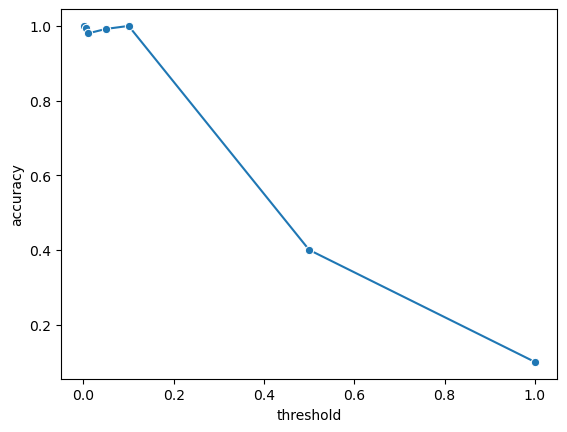

In [24]:
## plotting the results
results_df = pd.DataFrame(results_dict)

sns.lineplot(data=results_df, x='threshold', y='accuracy', marker='o')


In [2]:
nnx.list?

Object `nnx.list` not found.


In [10]:
aa = jnp.logspace(-4, 0, 20)
aa

Array([1.00000005e-04, 1.62377648e-04, 2.63665133e-04, 4.28133208e-04,
       6.95192954e-04, 1.12883793e-03, 1.83298055e-03, 2.97635212e-03,
       4.83293040e-03, 7.84759875e-03, 1.27427522e-02, 2.06913799e-02,
       3.35981734e-02, 5.45559525e-02, 8.85866731e-02, 1.43845022e-01,
       2.33572155e-01, 3.79268974e-01, 6.15848362e-01, 1.00000000e+00],      dtype=float32)